## Imports and Setup

In [1]:
import os
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../utils/")
import data_utils
import config_utils
import pred_utils
import model_utils
import cnn_utils

%load_ext autoreload
%autoreload 2

## Data Configurations

In [3]:
iso_code = "GHA"
shapename = "Bambey"
cwd = os.path.dirname(os.getcwd())

# Model configuration file
model_config_file = os.path.join(cwd, f"configs/cnn_configs/convnext_base_v01.yaml")
model_config = config_utils.load_config(model_config_file)
model_config["iso_codes"] = [iso_code]
classes = {1: model_config["pos_class"], 0: model_config["neg_class"]}

# Model file
exp_dir = os.path.join(
    cwd, model_config["exp_dir"], model_config["project"], f"{iso_code}_{model_config['config_name']}"
)
model_file = os.path.join(exp_dir, f"{iso_code}_{model_config['config_name']}.pth")
model = pred_utils.load_cnn(model_config, classes, model_file)

INFO:root:Device: cpu
INFO:root:Model file /home/itingzon.unicef/giga/exp/GIGAv2/GHA_convnext_base_v01/GHA_convnext_base_v01.pth successfully loaded.


## Load Training/Test Data

In [9]:
data = model_utils.load_data(model_config, attributes=["rurban", "iso"], verbose=False)
filepaths = data_utils.get_image_filepaths(model_config, data)
data[data['class'] == 'school'].sample(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry
3281,UNICEF-GHA-SCHOOL-00021797,UNICEF,GHA,Ghana,Africa,Sub-Saharan Africa,PINDA PRIMARY,361275a7-6853-315c-aa3a-aa0a88667601,0,0.0,school,12,rural,train,POINT (-96316.036 1352822.671)
3773,UNICEF-GHA-SCHOOL-00022920,UNICEF,GHA,Ghana,Africa,Sub-Saharan Africa,NADOWLI R/C J.H.S 'A',14469cdf-a68e-34be-8cbb-b847d4618321,0,0.0,school,12,rural,train,POINT (-263980.040 1280191.876)
6790,UNICEF-GHA-SCHOOL-00031858,UNICEF,GHA,Ghana,Africa,Sub-Saharan Africa,LIKPE KUKURANTUMI EP BASIC SCHOOL,51a29886-1eca-35cc-9a52-653545d52fcf,0,0.0,school,22,urban,train,POINT (56916.676 897027.777)


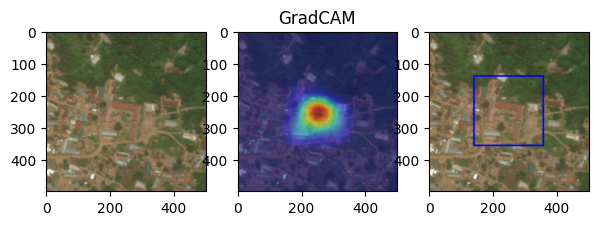

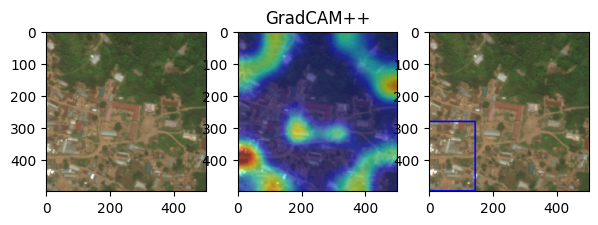

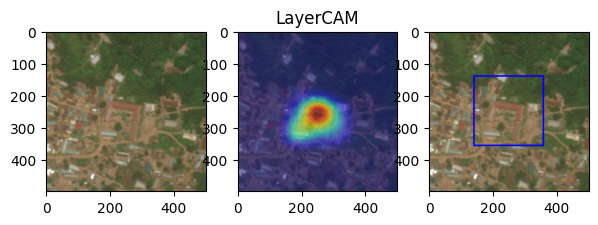

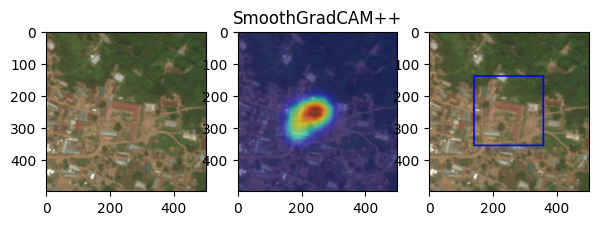

In [11]:
index = 6790 #2116
pred_utils.compare_cams(filepaths[index], model, model_config, classes, model_file)

## Load Model Outputs

In [22]:
name = f"{iso_code}_{shapename}"
out_dir = os.path.join(cwd, "output", iso_code, "results")
out_file = os.path.join(out_dir, f"{name}_{model_config['config_name']}_results.gpkg")

data = gpd.read_file(out_file)
sat_dir = os.path.join(cwd, "output", iso_code, "images", shapename)
filepaths = data_utils.get_image_filepaths(model_config, data, in_dir=sat_dir)
data[data['pred'] == 'school'].sample(3)

,UID,shapeName,pred,prob,geometry
10984,63519,Bambey,school,0.614303,"POLYGON ((-1828948.209 1651321.135, -1828948.2..."
10402,60537,Bambey,school,0.865124,"POLYGON ((-1830298.209 1654921.135, -1830298.2..."
6150,40259,Bambey,school,0.986953,"POLYGON ((-1839448.209 1669321.135, -1839448.2..."


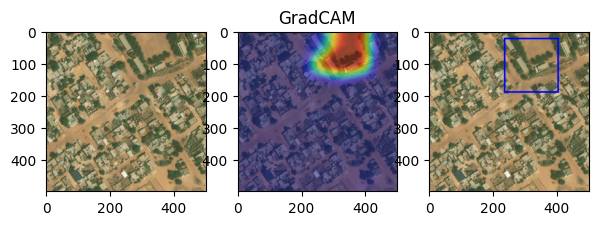

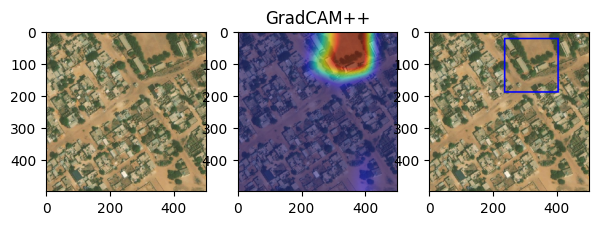

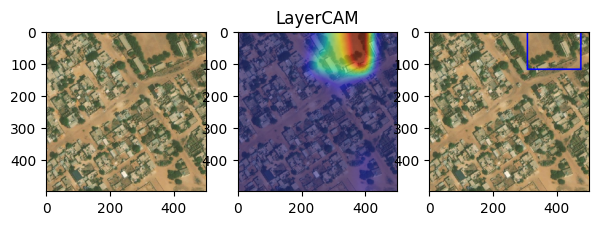

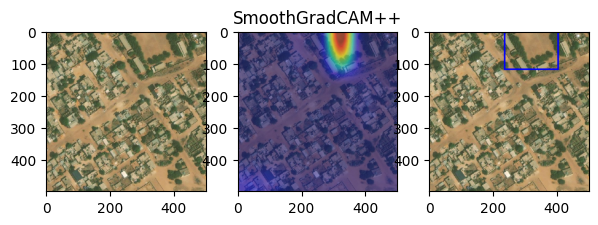

In [5]:
index = 26173
pred_utils.compare_cams(filepaths[index], model, model_config, classes, model_file)

## Visualize CAMs for Different Images

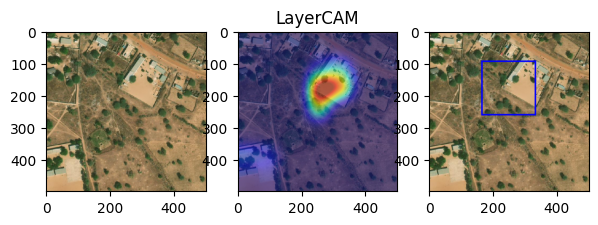

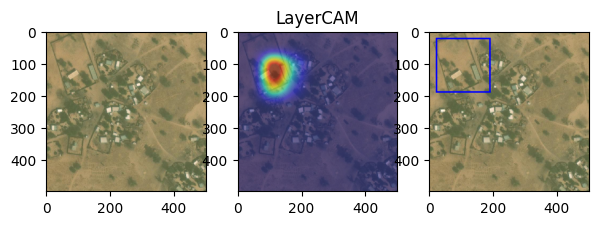

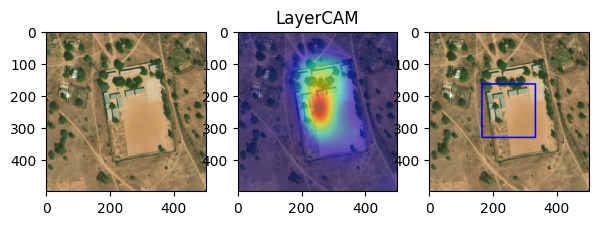

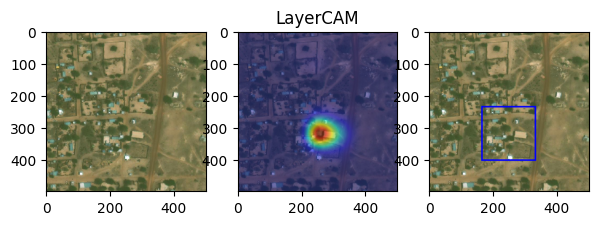

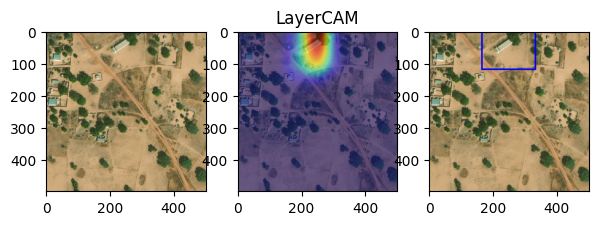

In [7]:
from torchcam.methods import LayerCAM
model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
cam_extractor = LayerCAM(model)

for index in list(data[data['pred'] == 'school'].sample(5).index):
    _, bbox = pred_utils.generate_cam(model_config, filepaths[index], model, cam_extractor, title="LayerCAM")

## Georeference Images

In [23]:
sat_config_file = os.path.join(cwd, 'configs/sat_configs/sat_config_500x500_60cm.yaml')
sat_config = config_utils.load_config(sat_config_file)
geotiff_dir = data_utils._makedir(os.path.join("output", iso_code, "geotiff", shapename))
pred_utils.georeference_images(data[data["pred"] == "school"], sat_config, sat_dir, geotiff_dir)

  0%|                                                                                           | 0/638 [00:00<?, ?it/s]/home/itingzon.unicef/miniconda3/envs/giga2/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|█████████████████████████████████████████████████████████████████████████████████| 638/638 [01:26<00:00,  7.35it/s]


## Generate Bounding Boxes from CAMs

In [24]:
from torchcam.methods import LayerCAM
model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
cam_extractor = LayerCAM(model)
results = pred_utils.generate_cam_bboxes(
    data[data['pred'] == 'school'].reset_index(drop=True), 
    model_config,
    geotiff_dir, 
    model, 
    cam_extractor
)
out_dir = os.path.join(cwd, "output", iso_code, "results")
filename = f"{iso_code}_{shapename}_{model_config['model']}_cam.gpkg"
out_file = os.path.join(out_dir, filename)
results.to_file(out_file, driver="GPKG")

100%|█████████████████████████████████████████████████████████████████████████████████| 638/638 [29:07<00:00,  2.74s/it]
